In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Snap-to-grid/submission_snap_to_grid.csv
/kaggle/input/train-meta-sub/train_meta_sub.csv
/kaggle/input/indoor-location-navigation/sample_submission.csv
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/B1/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F3/floor_image.png
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/geojson_map.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/floor_info.json
/kaggle/input/indoor-location-navigation/metadata/5cd56c0ce2acfd2d33b6ab27/F2/f

In [2]:
import json
import re
import gc
import pickle
import itertools
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime as dt
from pathlib import Path
from tqdm import tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # ut(10 digit) -> date

# pandas settings -----------------------------------------
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.5f}'.format

# Graph drawing -------------------------------------------
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib_venn import venn2, venn2_circles
from matplotlib import animation as ani
from IPython.display import Image
from pylab import imread

plt.rcParams["patch.force_edgecolor"] = True
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

%matplotlib inline
%config InlineBackend.figure_format='retina'

# ML -------------------------------------------
from sklearn.preprocessing import LabelEncoder


import dill
from collections import defaultdict, OrderedDict
from scipy.spatial import distance

In [3]:
def unpickle(file_name):
    with open(file_name,'rb') as f:
        p = pickle.load(f)
    return p

def to_pickle(file_name, obj):
    with open(file_name,'wb') as f:
        pickle.dump(obj,f,-1)

In [4]:
class FeatureStore():
    
    floor_convert = {'1F' :  0, '2F' : 1, '3F' : 2, '4F' : 3, '5F' : 4, 
                     '6F' : 5, '7F' : 6, '8F' : 7, '9F' : 8,
                     'B'  : -1, 'B1' : -1, 'B2' : -2, 'B3' : -3, 
                     'BF' : -1, 'BM' : -1, 
                     'F1' : 0, 'F2' : 1, 'F3' : 2, 'F4' : 3, 'F5' : 4, 
                     'F6' : 5, 'F7' : 6, 'F8' : 7, 'F9' : 8, 'F10': 9,
                     'L1' : 0, 'L2' : 1, 'L3' : 2, 'L4' : 3, 'L5' : 4, 
                     'L6' : 5, 'L7' : 6, 'L8' : 7, 'L9' : 8, 'L10': 9, 
                     'L11': 10,
                     'G'  : 0, 'LG1': 0, 'LG2': 1, 'LM' : 0, 'M'  : 0, 
                     'P1' : 0, 'P2' : 1,}
    df_types = ['accelerometer',
                'accelerometer_uncalibrated',
                'beacon',
                'gyroscope',
                'gyroscope_uncalibrated',
                'magnetic_field',
                'magnetic_field_uncalibrated',
                'rotation_vector',
                'waypoint',
                'wifi']
    
    df_type_cols = {'accelerometer': ["timestamp", "x", "y", "z", "accuracy"],
                'accelerometer_uncalibrated': ["timestamp", "x", "y", "z", 
                                               "x2", "y2", "z2", "accuracy" ],
                'beacon': ["timestamp", "uuid", "major_id", "minor_id", "tx_power", 
                           "rssi", "distance", "mac_addr", "timestamp2"],
                'gyroscope': ["timestamp", "x", "y", "z", "accuracy"],
                'gyroscope_uncalibrated': ["timestamp", "x", "y", "z", 
                                           "x2", "y2", "z2", "accuracy" ],
                'magnetic_field': ["timestamp", "x", "y", "z", "accuracy"],
                'magnetic_field_uncalibrated': ["timestamp", "x", "y", "z", 
                                                "x2", "y2", "z2", "accuracy" ],
                'rotation_vector': ["timestamp", "x", "y", "z", "accuracy"],
                'waypoint': ["timestamp", "x", "y"],
                'wifi': ["timestamp", "ssid", "bssid","rssi","frequency",
                         "last_seen_timestamp",]}
    
    dtype_dict = {}
    dtype_dict["accelerometer"] = {"timestamp":int, "x":float, "y":float, "z":float, 
                                   "accuracy":int}
    dtype_dict["accelerometer_uncalibrated"] = {"timestamp":int, "x":float, "y":float, 
                                                "z":float, "x2":float, "y2":float, 
                                                "z2":float, "accuracy":int}
    dtype_dict["beacon"] = {"timestamp":int, "uuid":str, "major_id":str, 
                            "minor_id":str, "tx_power":int,  "rssi":int, 
                            "distance":float, "mac_addr":str, "timestamp2":int}
    dtype_dict["gyroscope"] = {"timestamp":int, "x":float, "y":float, "z":float, 
                               "accuracy":int}
    dtype_dict["gyroscope_uncalibrated"] = {"timestamp":int, "x":float, "y":float, 
                                            "z":float, "x2":float, "y2":float, 
                                            "z2":float, "accuracy":int}
    dtype_dict["magnetic_field"] = {"timestamp":int, "x":float, "y":float, 
                                    "z":float, "accuracy":int}
    dtype_dict["magnetic_field_uncalibrated"] = {"timestamp":int, "x":float, 
                                                 "y":float, "z":float, "x2":float, 
                                                 "y2":float, "z2":float, "accuracy":int}
    dtype_dict["rotation_vector"] = {"timestamp":int, "x":float, "y":float, 
                                     "z":float, "accuracy":int}
    dtype_dict["waypoint"] = {"timestamp":int, "x":float, "y":float, "z":float}
    dtype_dict["wifi"] = {"timestamp":int, "ssid":str, "bssid":str,
                          "rssi":int,"frequency":int, "last_seen_timestamp":int}
    
    def __init__(self,site_id,floor,path_id,
                input_path = '../input/indoor-location-navigation/',
                save_path = '../mid'):
        self.site_id = site_id.strip()
        self.floor = floor.strip()
        self.n_floor = self.floor_convert[self.floor]
        self.path_id = path_id.strip()
        self.input_path = input_path
        assert Path(input_path).exists(), f"input_path do not exist: {input_path}"
        self.save_path = save_path
        Path(save_path).mkdir(parents=True, exist_ok=True)
        
        self.site_info = SiteInfo(site_id=self.site_id, floor=self.floor, input_path=self.input_path)
        
    def flatten(self,l):
        return list(itertools.chain.from_iterable(l))
    
    def multi_line_spliter(self,s):
        matches = re.finditer("TYPE_",s)
        match_pos = [match.start() for match in matches]
        split_idx = [0] + [match_pos[i] - 14 for i in range(1,len(match_pos))] + [len(s)]
        return [s[split_idx[i]:split_idx[i+1]] for i in range(len(split_idx)-1)]
    
    def load_data(self,):
        path = str(Path(self.input_path)/f"train/{self.site_id}/{self.floor}/{self.path_id}.txt")
        with open(path) as f:
            data = f.readlines()
        
        modified_data = []
        for s in data:
            if s.count("TYPE_")>1:
                lines = self.multi_line_spliter(s)
                modified_data.extend(lines)
            else:
                modified_data.append(s)
        
        del data
        self.meta_info_len = [d for d in modified_data if d[0]=='#']
        self.meta_info_df = pd.DataFrame([m.replace("\n", "").split(":") 
                                          for m in self.flatten([d.split("\t") 
                                                                  for d in modified_data if d[0]=="#"]) if m!="#"])
        
        data_df = pd.DataFrame([d.replace("\n", "").split("\t") for d in modified_data if d[0]!="#"])
        for dt in self.df_types:
            # select data type
            df_s = data_df[data_df[1]==f"TYPE_{dt.upper()}"]
            if len(df_s)==0:
                setattr(self, dt, pd.DataFrame(columns=self.df_type_cols[dt]))
            else:
                # remove empty cols
                na_info = df_s.isna().sum(axis=0) == len(df_s)
                df_s = df_s[[i for i in na_info[na_info==False].index if i!=1]].reset_index(drop=True)
                
                if len(df_s.columns)!=len(self.df_type_cols[dt]):
                    df_s.columns = self.df_type_cols[dt][:len(df_s.columns)]
                else:
                    df_s.columns = self.df_type_cols[dt]
            
                # set dtype          
                for c in df_s.columns:
                    df_s[c] = df_s[c].astype(self.dtype_dict[dt][c])
                                     
                # set DataFrame to attr
                setattr(self, dt, df_s)
    def get_site_info(self, keep_raw=False):
        self.site_info.get_site_info(keep_raw=keep_raw)
            
    def load_all_data(self, keep_raw=False):     
        self.load_data()
        self.get_site_info(keep_raw=keep_raw)
        
    def __getitem__(self, item):
        if item in self.df_types:
            return getattr(self, item)
        else:
            return None
    
    def save(self, ):
        # to be implemented
        pass
                

In [5]:
class SiteInfo():
    def __init__(self, site_id, floor, input_path="../input/indoor-location-navigation/"):
        self.site_id = site_id
        self.floor = floor
        self.input_path = input_path
        assert Path(input_path).exists(), f"input_path do not exist: {input_path}"
        
    def get_site_info(self, keep_raw=False):
        floor_info_path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/floor_info.json"
        with open(floor_info_path, "r") as f:
            self.floor_info = json.loads(f.read())
            self.site_height = self.floor_info["map_info"]["height"]
            self.site_width = self.floor_info["map_info"]["width"]
            if not keep_raw:
                del self.floor_info
            
        geojson_map_path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/geojson_map.json"
        with open(geojson_map_path, "r") as f:
            self.geojson_map = json.loads(f.read())
            self.map_type = self.geojson_map["type"]
            self.features = self.geojson_map["features"]
            
            self.floor_coordinates = self.features[0]["geometry"]["coordinates"]
            self.store_coordinates = [self.features[i]["geometry"]["coordinates"] 
                                          for i in range(1, len(self.features))]
                
            if not keep_raw:
                del self.geojson_map
    def show_site_image(self):
        path = f"{self.input_path}/metadata/{self.site_id}/{self.floor}/floor_image.png"
        plt.imshow(imread(path), extent=[0, self.site_width, 0, self.site_height])
        
    def draw_polygon(self, size=8, only_floor=False):

        fig = plt.figure()
        ax = plt.subplot(111)
            
        xmax, xmin, ymax, ymin = self._draw(self.floor_coordinates, ax, calc_minmax=True)
        if not only_floor:
            self._draw(self.store_coordinates, ax, fill=True)
        plt.legend([])
        
        xrange = xmax - xmin
        yrange = ymax - ymin
        ratio = yrange / xrange
        
        self.x_size = size
        self.y_size = size*ratio

        fig.set_figwidth(size)
        fig.set_figheight(size*ratio)
        # plt.show()
        return ax
        
    def _draw(self, coordinates, ax, fill=False, calc_minmax=False):
        xmax, ymax = -np.inf, -np.inf
        xmin, ymin = np.inf, np.inf
        for i in range(len(coordinates)):
            ndim = np.ndim(coordinates[i])
            if ndim==2:
                corrd_df = pd.DataFrame(coordinates[i])
                if fill:
                    ax.fill(corrd_df[0], corrd_df[1], alpha=0.7)
                else:
                    corrd_df.plot.line(x=0, y=1, style="-", ax=ax)
                        
                if calc_minmax:
                    xmax = max(xmax, corrd_df[0].max())
                    xmin = min(xmin, corrd_df[0].min())

                    ymax = max(ymax, corrd_df[1].max())
                    ymin = min(ymin, corrd_df[1].min())
            elif ndim==3:
                for j in range(len(coordinates[i])):
                    corrd_df = pd.DataFrame(coordinates[i][j])
                    if fill:
                        ax.fill(corrd_df[0], corrd_df[1], alpha=0.6)
                    else:
                        corrd_df.plot.line(x=0, y=1, style="-", ax=ax)
                        
                    if calc_minmax:
                        xmax = max(xmax, corrd_df[0].max())
                        xmin = min(xmin, corrd_df[0].min())

                        ymax = max(ymax, corrd_df[1].max())
                        ymin = min(ymin, corrd_df[1].min())
            else:
                assert False, f"ndim of coordinates should be 2 or 3: {ndim}"
        if calc_minmax:
            return xmax, xmin, ymax, ymin
        else:
            return None

In [6]:
train_meta = glob("../input/indoor-location-navigation/train/*/*/*")
train_meta_org = pd.DataFrame(train_meta)
train_meta = train_meta_org[0].str.split("/",expand=True)[[4,5,6]]
train_meta.columns = ["site_id","floor","path_id"]
train_meta["path_id"] = train_meta["path_id"].str.replace(".txt","")
train_meta["path"] = train_meta_org[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [7]:
train_meta.head()

site_id floor                   path_id  \
0  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625bd54340008acddb9   
1  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625bd54340008acddb7   
2  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625249b920008be0cba   
3  5cd56c0ce2acfd2d33b6ab27    B1  5d09a625249b920008be0cbc   
4  5cd56c0ce2acfd2d33b6ab27    F3  5d09b23fcfb49b00085466aa   

                                                                                                 path  
0  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625bd54340008acddb9.txt  
1  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625bd54340008acddb7.txt  
2  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625249b920008be0cba.txt  
3  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/B1/5d09a625249b920008be0cbc.txt  
4  ../input/indoor-location-navigation/train/5cd56c0ce2acfd2d33b6ab27/F3/5d09b23fcfb49b00085466aa.txt

In [8]:
def pickle_dump_dill(obj, path):
    with open(path, mode='wb') as f:
        dill.dump(obj, f)


def pickle_load_dill(path):
    with open(path, mode='rb') as f:
        data = dill.load(f)
        return data

In [9]:
sample_sub = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv')
test_sites = sample_sub.site_path_timestamp.apply(lambda x: pd.Series(x.split("_")))[0].unique().tolist()
test_meta = sample_sub.site_path_timestamp.apply(lambda x: pd.Series(x.split("_")))
test_meta.columns = ["site_id","path_id","timestamp"]
test_meta.drop("timestamp",axis=1,inplace=True)
test_meta  = test_meta.drop_duplicates(subset=["site_id","path_id"]).reset_index(drop=True)

In [10]:
create_train_meta_sub=False
if create_train_meta_sub:
    train_meta_sub=train_meta[train_meta['site_id'].isin(test_sites)].reset_index(drop=True)
    train_meta_sub['start_time']=0
    train_meta_sub['end_time']=0
    train_meta_sub['start_wp_time']=0
    train_meta_sub['start_wp_x']=0
    train_meta_sub['start_wp_y']=0
    train_meta_sub['end_wp_time']=0
    train_meta_sub['end_wp_x']=0
    train_meta_sub['end_wp_y']=0
    train_meta_sub['n_floor']=0
    for i in tqdm(range(len(train_meta_sub))):
        t = train_meta_sub.iloc[i]
        n_floor = FeatureStore.floor_convert[t.floor]
        
        feature = FeatureStore(
            site_id=t.site_id, floor=t.floor, path_id=t.path_id)
        feature.load_all_data()
        start_time=int(feature.meta_info_df[feature.meta_info_df[0]=='startTime'][1])
        end_time=int(feature.meta_info_df[feature.meta_info_df[0]=="endTime"][1])
        train_meta_sub.loc[i,"start_time"]=start_time
        train_meta_sub.loc[i,"start_wp_time"]=feature.waypoint.iloc[0]["timestamp"]
        train_meta_sub.loc[i,"start_wp_x"]=feature.waypoint.iloc[0]["x"]
        train_meta_sub.loc[i,"start_wp_y"]=feature.waypoint.iloc[0]["y"]
        train_meta_sub.loc[i,"end_time"]=end_time
        train_meta_sub.loc[i,"end_wp_time"]=feature.waypoint.iloc[-1]["timestamp"]
        train_meta_sub.loc[i,"end_wp_x"]=feature.waypoint.iloc[-1]["x"]
        train_meta_sub.loc[i,"end_wp_y"]=feature.waypoint.iloc[-1]["y"]
        train_meta_sub.loc[i,"n_floor"]=feature.n_floor
    train_meta_sub.to_csv('train_meta_sub.csv', index=False)
else:
    train_meta_sub = pd.read_csv('../input/indoor-location-2/train_meta_sub.csv')
        
        

In [11]:
train_meta_sub[train_meta_sub.site_id=='5d2709b303f801723c327472'][['path_id','site_id','n_floor','start_time','start_wp_x','start_wp_y','end_time','end_wp_x','end_wp_y']].sort_values(['site_id','n_floor','start_time'])[:50]

path_id                   site_id  n_floor  \
747   5da828924091ff00060488a6  5d2709b303f801723c327472       -1   
724   5da82892ae6cfc0006ca8151  5d2709b303f801723c327472       -1   
759   5da828924091ff00060488a8  5d2709b303f801723c327472       -1   
726   5da82893ae6cfc0006ca8153  5d2709b303f801723c327472       -1   
756   5da828934091ff00060488aa  5d2709b303f801723c327472       -1   
728   5da82894ae6cfc0006ca8155  5d2709b303f801723c327472       -1   
752   5da828944091ff00060488ac  5d2709b303f801723c327472       -1   
738   5da82895ae6cfc0006ca8157  5d2709b303f801723c327472       -1   
751   5da828994091ff00060488b0  5d2709b303f801723c327472       -1   
761   5da82899ae6cfc0006ca815b  5d2709b303f801723c327472       -1   
737   5da8289bae6cfc0006ca815d  5d2709b303f801723c327472       -1   
750   5da8289c4091ff00060488b4  5d2709b303f801723c327472       -1   
760   5da8289cae6cfc0006ca815f  5d2709b303f801723c327472       -1   
723   5da8289d4091ff00060488b6  5d2709b303f801723c327472       -1   
745   5da8289dae6cfc0006ca8161  5d2709b303f801723c327472       -1   
735   5da8289e4091ff00060488b8  5d2709b303f801723c327472       -1   
744   5da8289eae6cfc0006ca8163  5d2709b303f801723c327472       -1   
722   5da8289f4091ff00060488ba  5d2709b303f801723c327472       -1   
754   5da8289fae6cfc0006ca8165  5d2709b303f801723c327472       -1   
753   5da828a04091ff00060488bc  5d2709b303f801723c327472       -1   
746   5da828a0ae6cfc0006ca8167  5d2709b303f801723c327472       -1   
764   5da828a04091ff00060488be  5d2709b303f801723c327472       -1   
741   5da828a1ae6cfc0006ca8169  5d2709b303f801723c327472       -1   
734   5da828a24091ff00060488c0  5d2709b303f801723c327472       -1   
729   5da829caae6cfc0006ca8176  5d2709b303f801723c327472       -1   
755   5da829cb4091ff00060488c2  5d2709b303f801723c327472       -1   
763   5da829cbae6cfc0006ca8178  5d2709b303f801723c327472       -1   
727   5da82b314091ff00060488c4  5d2709b303f801723c327472       -1   
739   5da82b32ae6cfc0006ca8183  5d2709b303f801723c327472       -1   
725   5da82b334091ff00060488c6  5d2709b303f801723c327472       -1   
749   5da82b33ae6cfc0006ca8185  5d2709b303f801723c327472       -1   
721   5da82b344091ff00060488c8  5d2709b303f801723c327472       -1   
743   5da82b34ae6cfc0006ca8187  5d2709b303f801723c327472       -1   
719   5da82c404091ff00060488d8  5d2709b303f801723c327472       -1   
720   5da82c41ae6cfc0006ca81a4  5d2709b303f801723c327472       -1   
748   5da82c414091ff00060488da  5d2709b303f801723c327472       -1   
758   5da82c424091ff00060488dc  5d2709b303f801723c327472       -1   
736   5da82c42ae6cfc0006ca81a6  5d2709b303f801723c327472       -1   
740   5dac107bdf065a00069bf0a1  5d2709b303f801723c327472       -1   
742   5dac107c18410e00067e70d5  5d2709b303f801723c327472       -1   
730   5dac107ddf065a00069bf0a3  5d2709b303f801723c327472       -1   
731   5dac107d18410e00067e70d7  5d2709b303f801723c327472       -1   
718   5dac11df18410e00067e70e7  5d2709b303f801723c327472       -1   
762   5dac11e1df065a00069bf0a9  5d2709b303f801723c327472       -1   
732   5dac132b18410e00067e70ec  5d2709b303f801723c327472       -1   
757   5dac132cdf065a00069bf0b7  5d2709b303f801723c327472       -1   
765   5dac132c18410e00067e70ee  5d2709b303f801723c327472       -1   
733   5dac132ddf065a00069bf0b9  5d2709b303f801723c327472       -1   
992   5da70adf0593fc000669a44d  5d2709b303f801723c327472        0   
1122  5da70ae1ab074400064328da  5d2709b303f801723c327472        0   

         start_time  start_wp_x  start_wp_y       end_time  end_wp_x  end_wp_y  
747   1571299003872    83.65372    23.77619  1571299021291  86.04880  13.69748  
724   1571299096145    86.04880    13.69748  1571299108069  80.06909  22.56134  
759   1571299123613    80.06909    22.56134  1571299144663  82.38376  12.64283  
726   1571299171376    83.65372    23.77619  1571299191906  75.30750  21.33308  
756   1571299215623    75.30750    21.33308  1571299244151  68.06525  29.47880  
728   15712992994

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


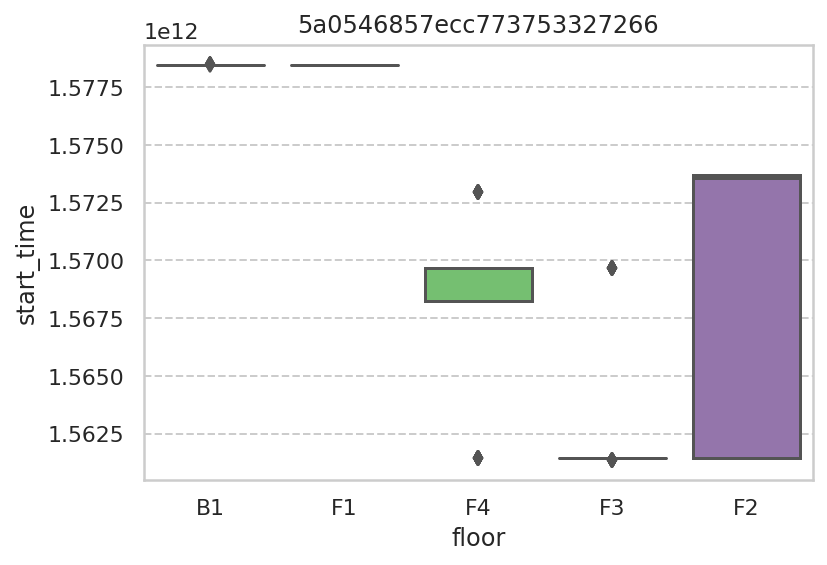

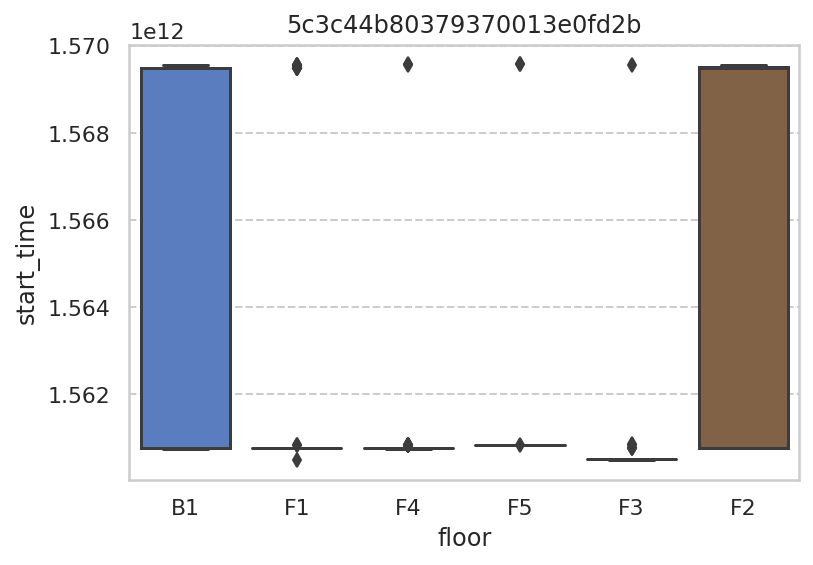

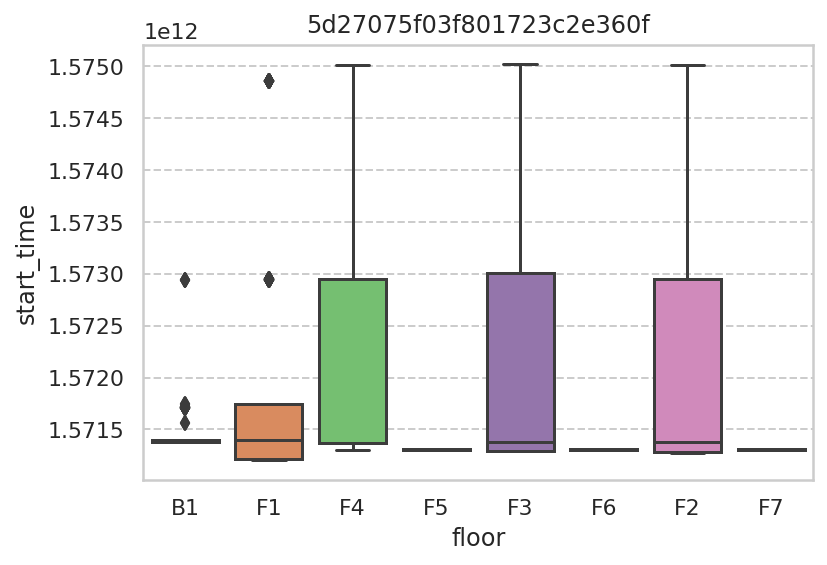

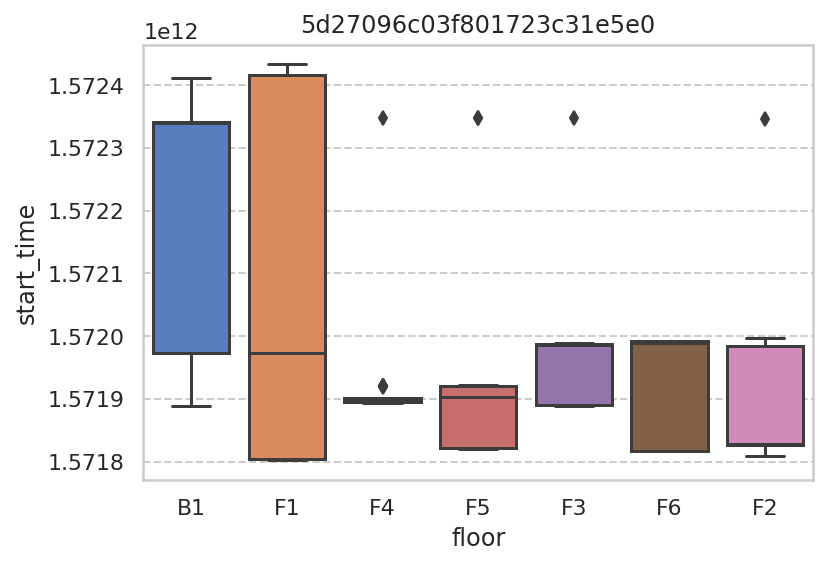

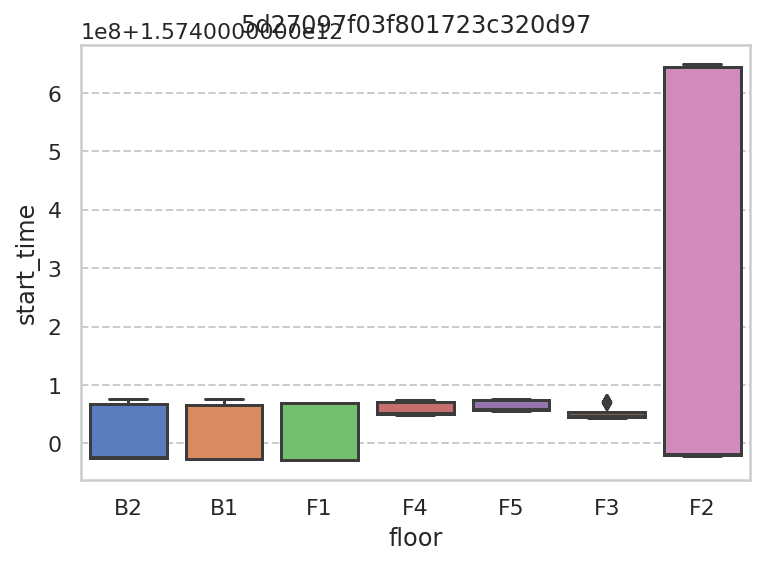

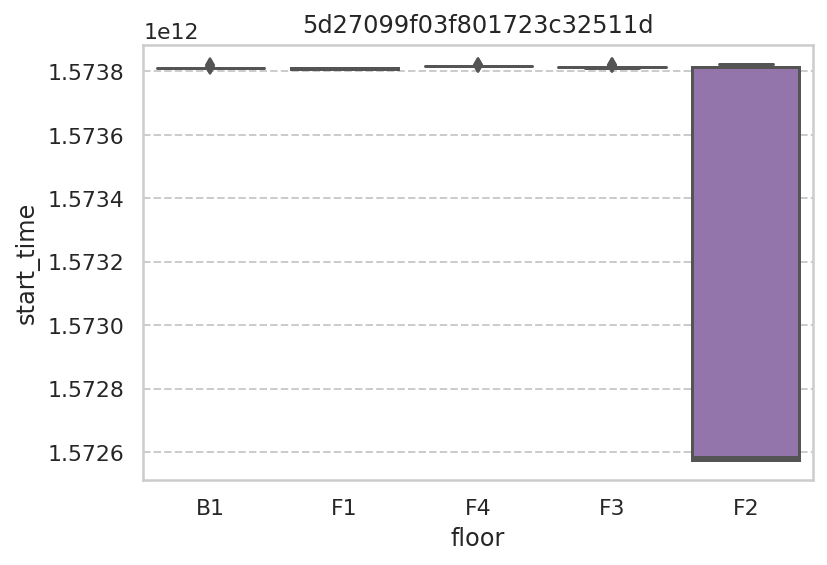

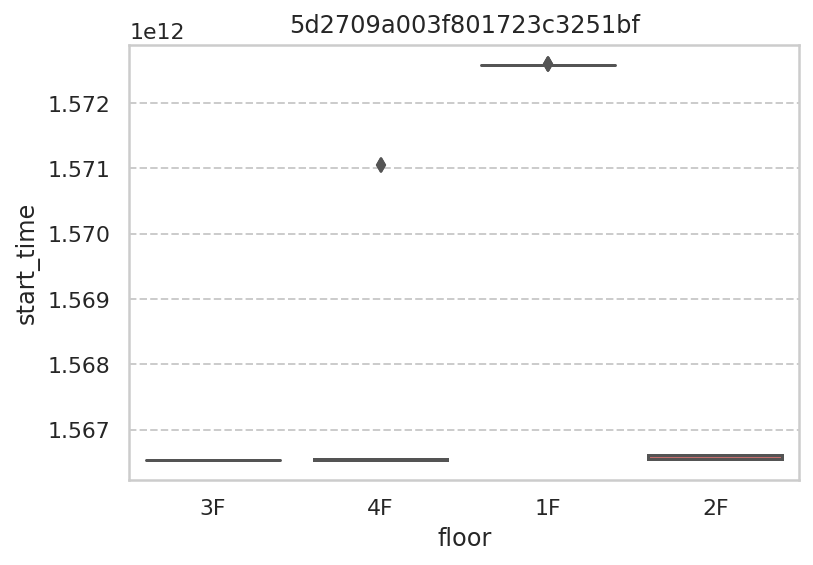

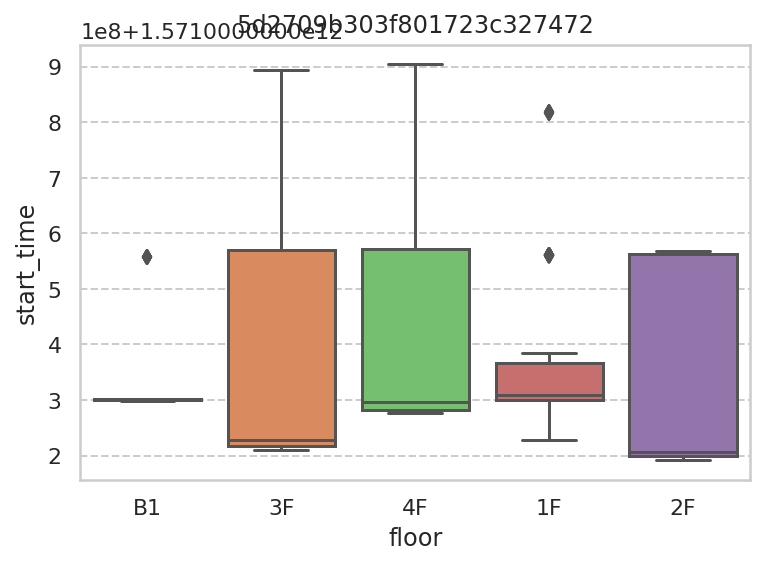

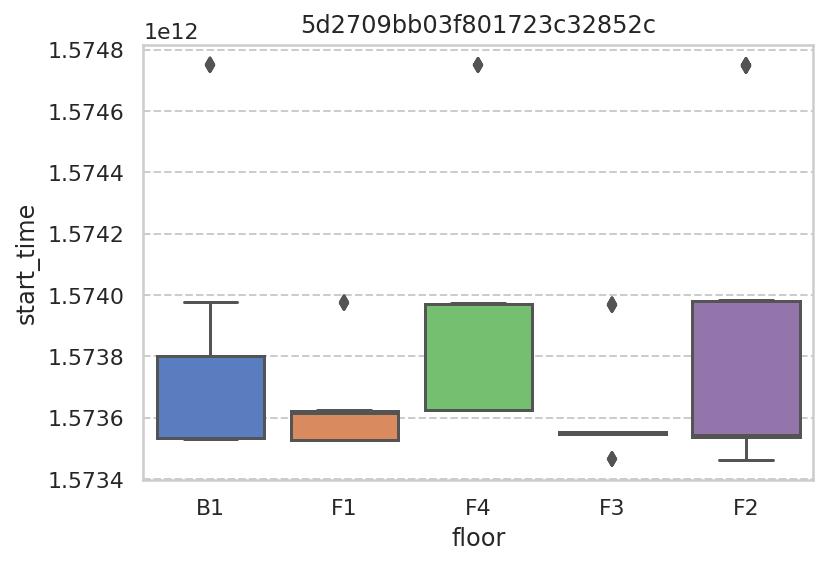

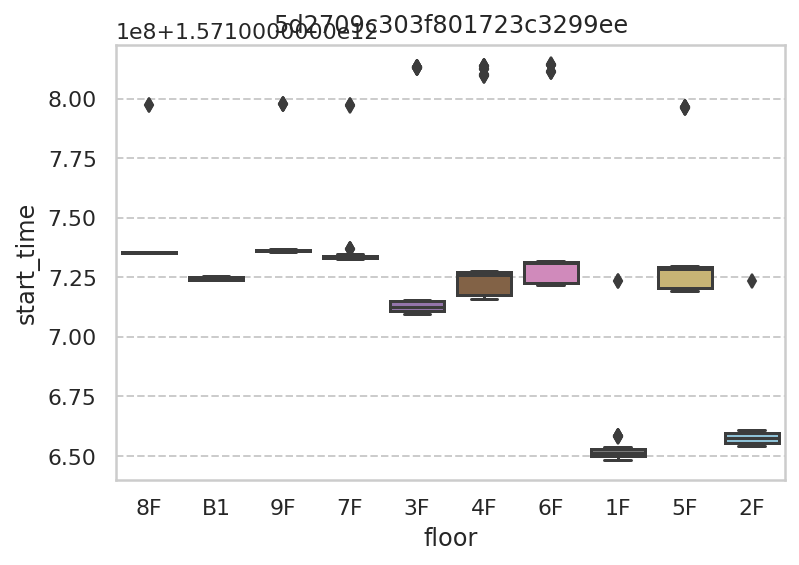

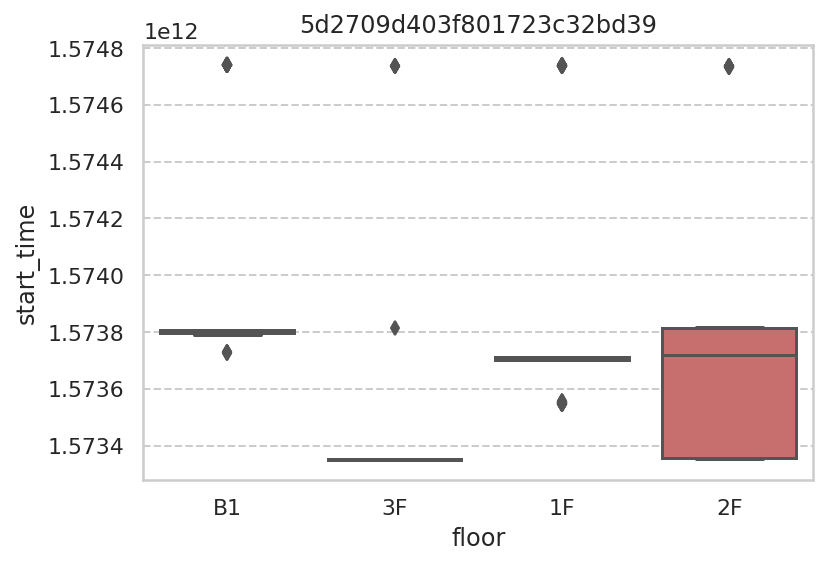

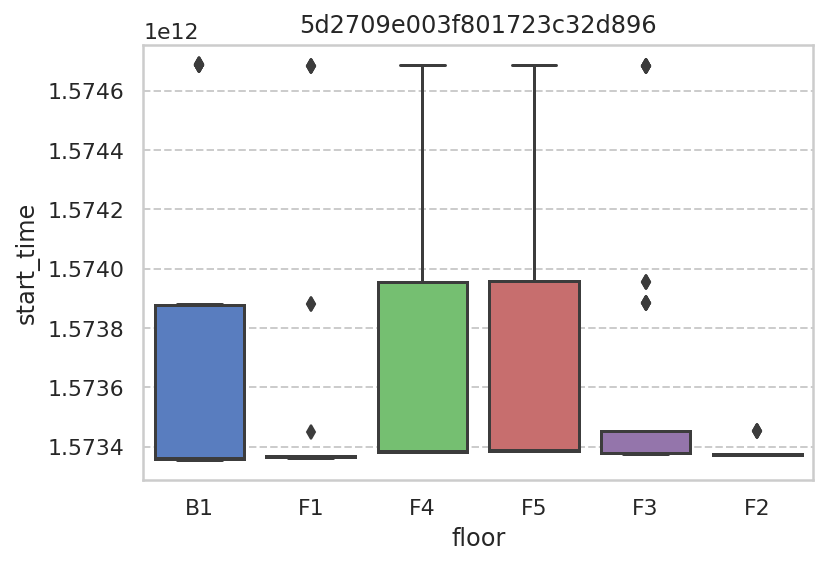

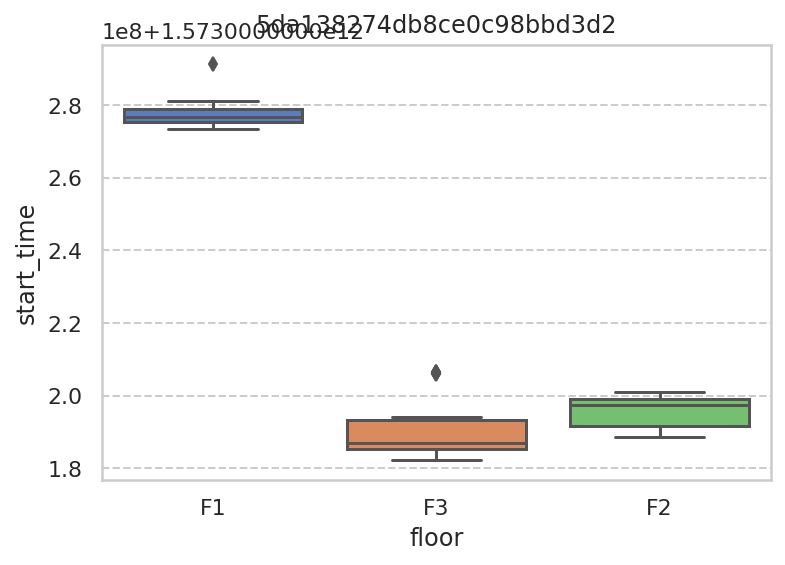

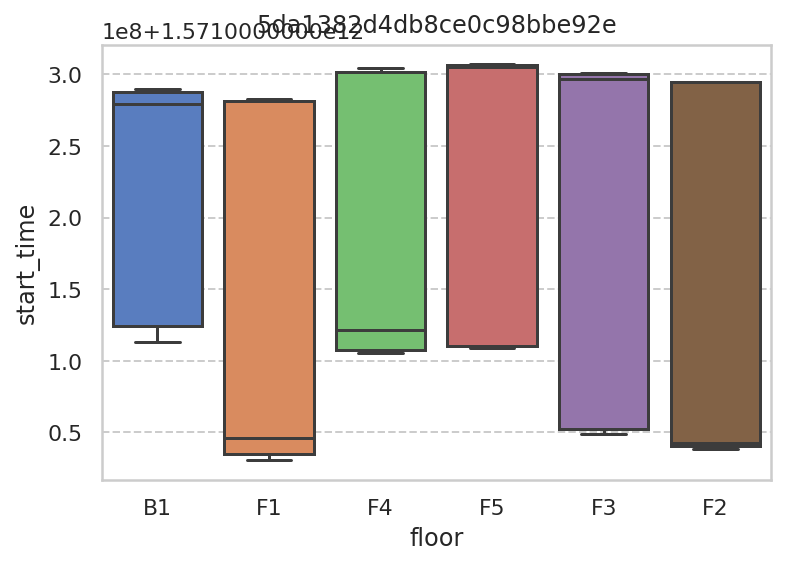

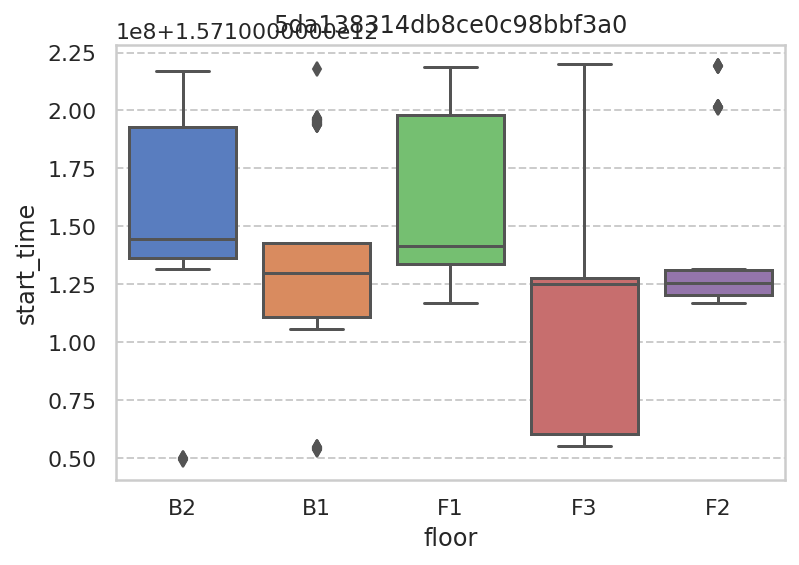

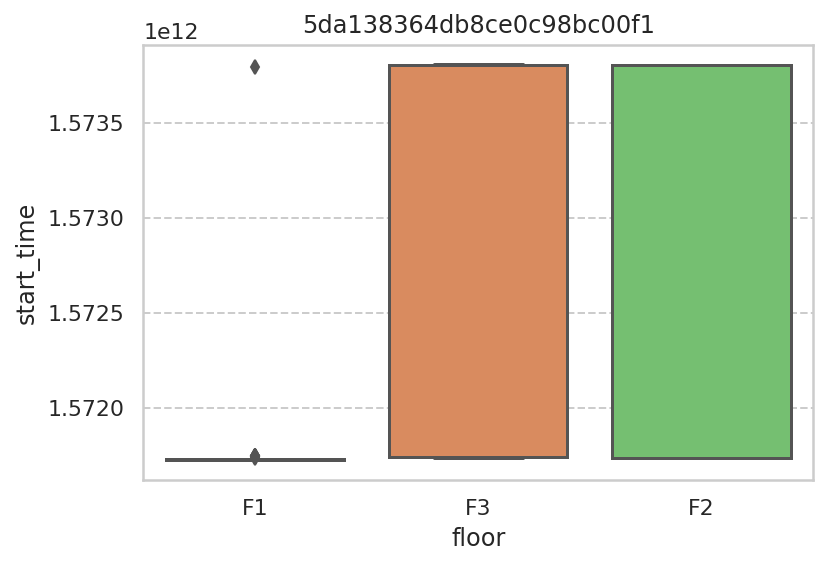

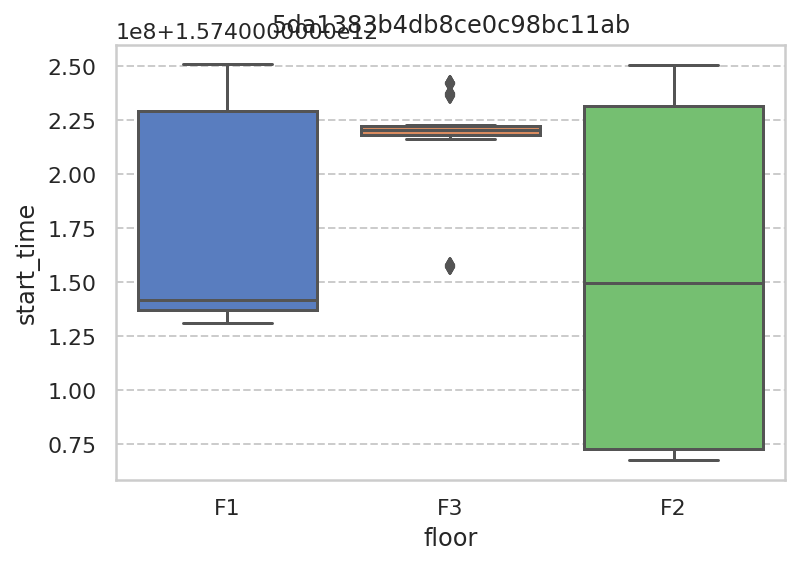

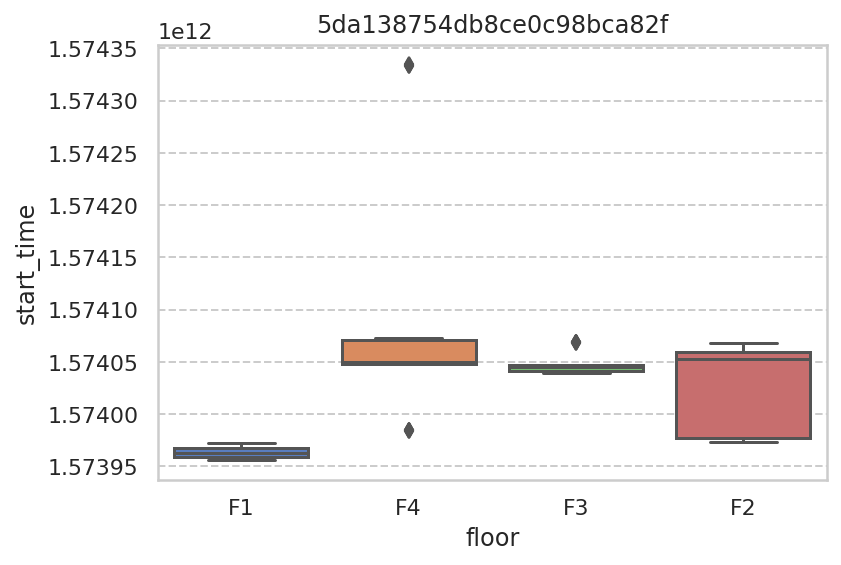

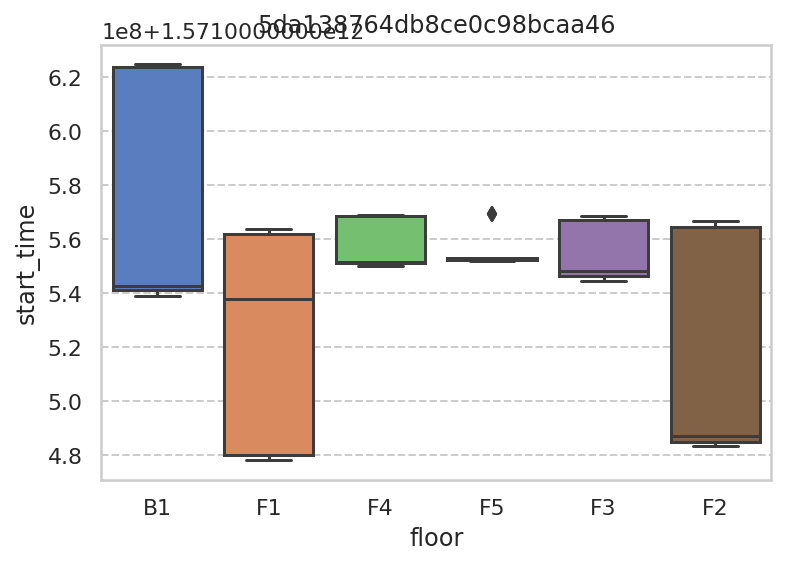

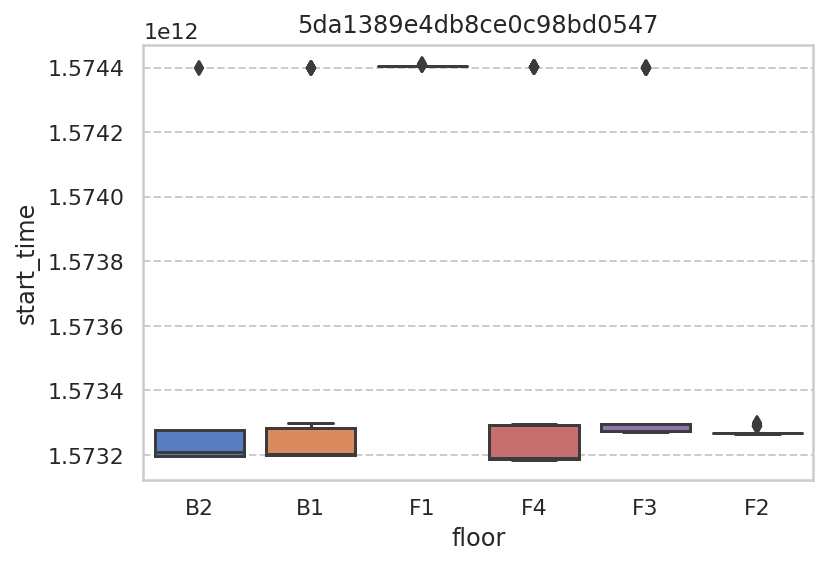

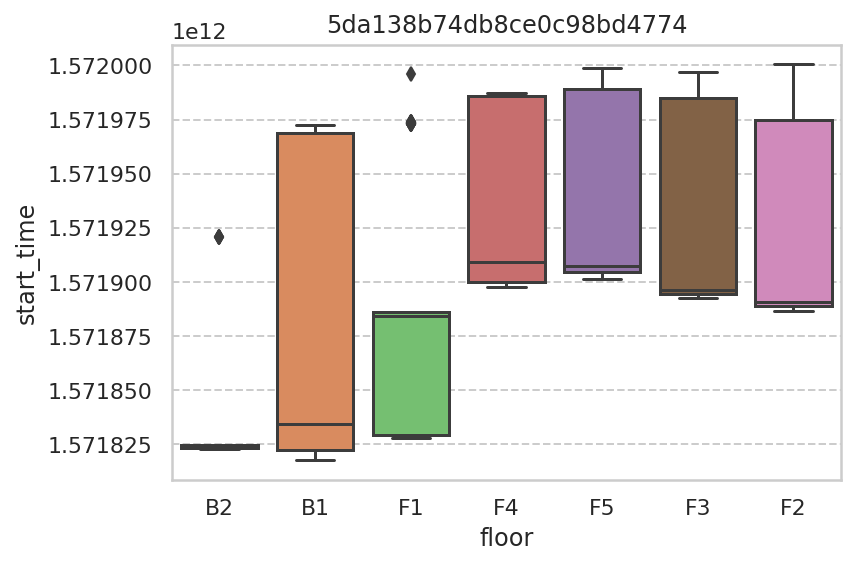

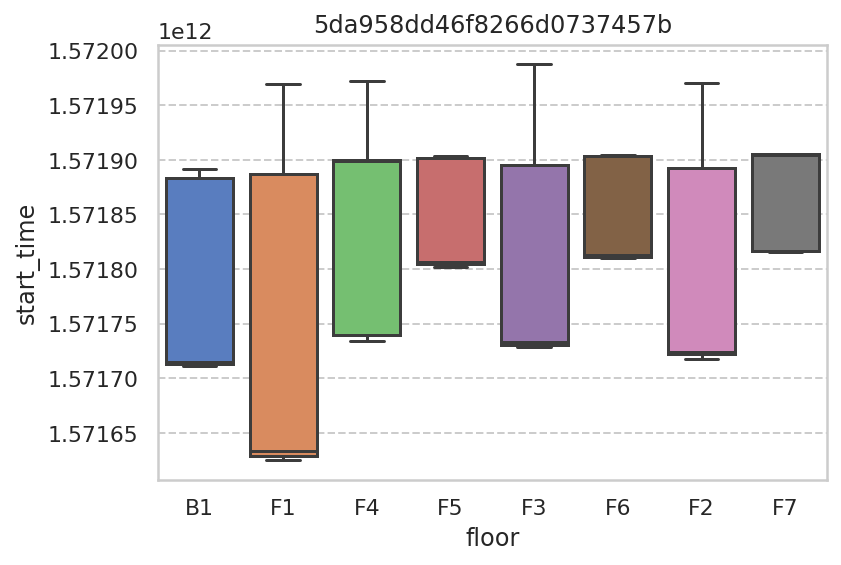

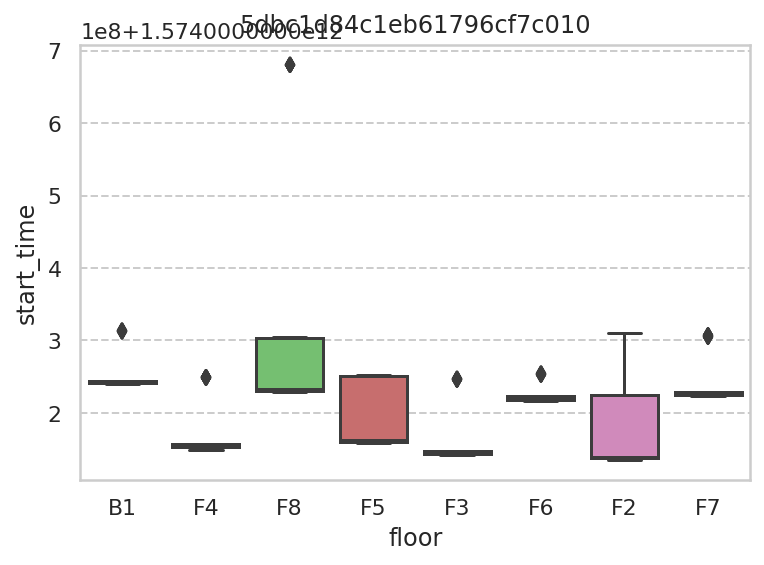

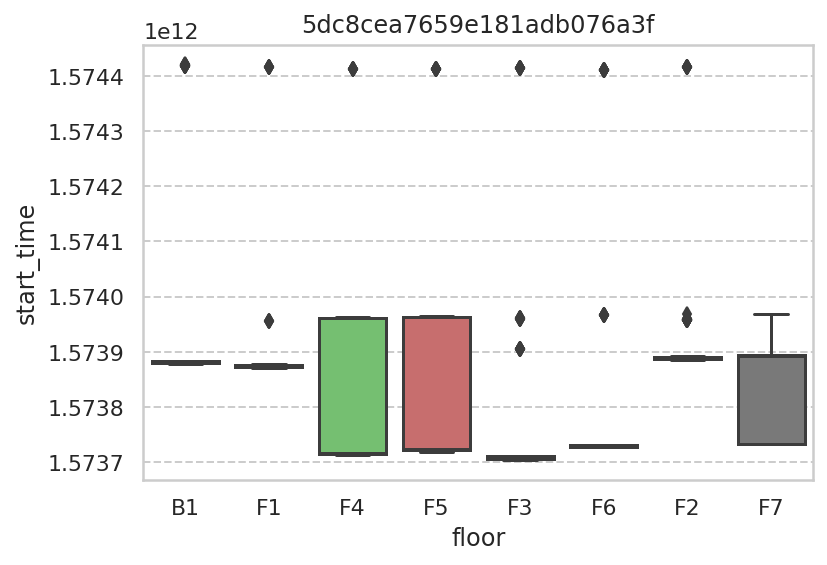

In [12]:
for test_site in test_sites:
    plt.figure()
    plt.title(test_site)
    sns.boxplot(x='floor', y='start_time',
                data=train_meta_sub[train_meta_sub.site_id==test_site])

In [13]:
def read_txt(file):
    with open(file,'r') as f:
        txt = f.readlines()
        
        modified_data=[]
        for i in txt:
            if i.count("TYPE_")>1:
                line = multi_line_splitter(i)
                modified_data.extend(line)
            else:
                modified_data.append(i)
                
                
    return modified_data

def _flatten(l):
    return list(itertools.chain.from_iterable(l))

def get_feature_test(site_id, path_id, input_path, sample_sub):
    path = f"{input_path}/test/{path_id}.txt"
    content = read_txt(path)
    data_df = pd.DataFrame([d.replace("\n","").split("\t")
                           for d in content if d[0] != "#"])
    data_dict = OrderedDict()
    for dt in FeatureStore.df_types:
        df_s = data_df[data_df[1] == f"TYPE_{dt.upper()}"]
        if len(df_s)==0:
            setattr(data_dict,dt,pd.DataFrame(
                columns=FeatureStore.df_type_cols[dt]))
        else:
            na_info = df_s.isna().sum(axis=0) == len(df_s)
            df_s = df_s[[i for i in na_info[na_info == False].index if i != 1]].reset_index(drop=True)
            if len(df_s.columns) != len(FeatureStore.df_type_cols[dt]):
                df_s.columns = FeatureStore.df_type_cols[dt][:len(df_s.columns)]
            else:
                df_s.columns = FeatureStore.df_type_cols[dt]
            for c in df_s.columns:
                df_s[c] = df_s[c].astype(FeatureStore.dtype_dict[dt][c])
            setattr(data_dict,dt,df_s)
    data_dict.meta_info_df = pd.DataFrame([m.replace("\n", "").split(":")
                                           for m in _flatten([d.split("\t")
                                                              for d in content if d[0] == "#"]) if m != "#"])
    startTime_ind = int(np.where(data_dict.meta_info_df[0] == "startTime")[0])
    endTime_ind = int(np.where(data_dict.meta_info_df[0]  == "endTime")[0])
    data_dict.meta_info_df.loc[startTime_ind,1] = data_dict.meta_info_df.loc[startTime_ind+1,0]
    data_dict.meta_info_df.loc[endTime_ind,1]  = data_dict.meta_info_df.loc[endTime_ind+1,0]
    data_dict.waypoint['timestamp'] = sample_sub[sample_sub.path_id ==
                                                 path_id].timestamp.values.astype(int)
    data_dict.waypoint['x'] = 0
    data_dict.waypoint['y'] = 0
    data_dict.n_floor = 0
    data_dict.site_id = site_id
    return data_dict
        

In [14]:
def leak_postprocessing(submission_df,train_meta, postprocess_start=True, postprocess_end=True, postprocess_floor=True,start_threshold=5500,end_threshold=5500):
    out_df= submission_df.copy()
    out_df[["site_id", "path_id", "timestamp"]] = out_df["site_path_timestamp"].apply(
        lambda x: pd.Series(x.split("_")))
    start_counter = 0
    end_counter = 0
    floor_counter = 0
    input_path='/kaggle/input/indoor-location-navigation/'
    sample_sub = pd.read_csv(f"{input_path}/sample_submission.csv")
    sample_sub = sample_sub["site_path_timestamp"].apply(lambda x:
                                                        pd.Series(x.split("_")))
    sample_sub.columns = ["site_id","path_id","timestamp"]
    out_df_unique = out_df.drop_duplicates(subset=["site_id",
                                                  "path_id"]).reset_index(drop=True)
    for i in tqdm(range(len(out_df_unique.path_id))):
        t = out_df_unique.iloc[i]
        site_id=t.site_id
        path_id=t.path_id
        feature = get_feature_test(site_id, path_id, input_path, sample_sub)
        if feature.meta_info_df[feature.meta_info_df[0] == 'startTime'][1].values == None:
            start_time = int(np.nanmin([feature.accelerometer.timestamp.min(
            ), feature.wifi.timestamp.min(), feature.beacon.timestamp.min()]))
        else:
            start_time = int(
                feature.meta_info_df[feature.meta_info_df[0] == 'startTime'][1])
        
        if (len(feature.meta_info_df[feature.meta_info_df[0] == 'endTime']) == 0) or (feature.meta_info_df[feature.meta_info_df[0] == 'endTime'][1].values == None):
            end_time = int(np.nanmax([feature.accelerometer.timestamp.max(
            ), feature.wifi.timestamp.max(), feature.beacon.timestamp.max()]))
        else:
            end_time = int(
                feature.meta_info_df[feature.meta_info_df[0] == 'endTime'][1])
            
        if len(feature.beacon) > 0:
                gap = feature.beacon.loc[0, 'timestamp2'] - \
                    feature.beacon.loc[0, 'timestamp']
        else:
            gap = (feature.wifi.last_seen_timestamp.values -
                   feature.wifi.timestamp.values).max()+210.14426803816337  # from mean gap
        site_id = feature.site_id
        train_meta_site = train_meta[train_meta.site_id == site_id]
        
        #postprocess start point based on leakage
        train_meta_site_end = train_meta_site[(
            start_time+gap) > train_meta_site.end_time]
        if len(train_meta_site_end) > 0:
            nearest_endpoint = train_meta_site_end.loc[train_meta_site_end.end_time.idxmax(
            )]
            if postprocess_start and (start_time + gap - nearest_endpoint.end_time < start_threshold):
                out_df.loc[(out_df.path_id == path_id) & (out_df.timestamp == 
                    out_df[out_df.path_id == path_id].timestamp.min()), 'x'] = nearest_endpoint.end_wp_x
                out_df.loc[(out_df.path_id == path_id) & (out_df.timestamp == 
                    out_df[out_df.path_id == path_id].timestamp.min()), 'y'] = nearest_endpoint.end_wp_y
                start_counter += 1
        
        #postprocess end point based on leakage
        train_meta_site_start = train_meta_site[train_meta_site.start_time > (
            end_time+gap)]
        if len(train_meta_site_start) > 0:
            nearest_startpoint = train_meta_site_start.loc[train_meta_site_start.start_time.idxmin(
            )]
            if postprocess_end and (nearest_startpoint.start_time - end_time - gap < end_threshold):
                out_df.loc[(out_df.path_id == path_id) & (out_df.timestamp == 
                    out_df[out_df.path_id == path_id].timestamp.max()), 'x'] = nearest_startpoint.start_wp_x
                out_df.loc[(out_df.path_id == path_id) & (out_df.timestamp == 
                    out_df[out_df.path_id == path_id].timestamp.max()), 'y'] = nearest_startpoint.start_wp_y
                end_counter += 1
                
        #postprocess floor based on leakage
        if postprocess_floor:
            if (len(train_meta_site_end) > 0) and (len(train_meta_site_start) > 0) and (nearest_endpoint.n_floor == nearest_startpoint.n_floor):
                out_df.loc[(out_df.path_id == path_id),
                                  'floor'] = nearest_endpoint.n_floor
                floor_counter += (out_df.path_id == path_id).sum()

            # uncomment this section if you want to postprocess all floor predictions
            # elif (len(train_meta_site_end) > 0) and (len(train_meta_site_start) > 0):
            #     diff_start_time = start_time - nearest_endpoint.end_time
            #     diff_end_time = nearest_startpoint.start_time - end_time
            #     if diff_start_time < diff_end_time:
            #         out_df.loc[(out_df.path_id == path_id),
            #                           'floor'] = nearest_endpoint.n_floor
            #         floor_counter += (out_df.path_id == path_id).sum()
            #     if diff_end_time < diff_start_time:
            #         out_df.loc[(out_df.path_id == path_id),
            #                           'floor'] = nearest_startpoint.n_floor
            #         floor_counter += (out_df.path_id == path_id).sum()
            # elif len(train_meta_site_end) > 0:
            #     out_df.loc[(out_df.path_id == path_id),
            #                       'floor'] = nearest_endpoint.n_floor
            #     floor_counter += (out_df.path_id == path_id).sum()
            # elif len(train_meta_site_start) > 0:
            #     out_df.loc[(out_df.path_id == path_id),
            #                       'floor'] = nearest_startpoint.n_floor
            #     floor_counter += (out_df.path_id == path_id).sum()
            
    print(str(start_counter) + ' start points are postprocessed.')
    print(str(end_counter) + ' end points are postprocessed.')
    print(str(floor_counter) + ' floors are postprocessed.')
    out_df = out_df.drop(
        ["site_id", "path_id", "timestamp"], axis=1)
    return out_df

In [15]:
submission_df = pd.read_csv('../input/Snap-to-grid/submission_snap_to_grid.csv')

In [16]:
submission_df_leak_start_end = leak_postprocessing(submission_df,train_meta_sub, postprocess_start=True, postprocess_end=True, postprocess_floor=False)
submission_df_leak_start_end.to_csv(
    'submission_df_leak_start_end.csv', index=False)

100%|██████████| 626/626 [07:28<00:00,  1.40it/s]

75 start points are postprocessed.
101 end points are postprocessed.
0 floors are postprocessed.
